In [1]:
import matplotlib as mpl
import matplotlib.patches as mpl_patches
from scipy.ndimage import median_filter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn

mpl.rc("text", usetex=False)

import cdetools
import corner
import flexcode
import qp
import rail
%config Completer.use_jedi = False
from scipy.interpolate import interp1d

Found classifier FZBoost
Found classifier BPZ_lite
Found classifier simpleNN
Found classifier trainZ
Found classifier randomPZ


### Estimating photo-$z$ posterior PDFs with FlexCode

A demonstration of `FlexCode` in the context of photo-$z$s can be found in [Dalmasso, et al 2019](https://arxiv.org/abs/1908.11523), with demos in `R` published on [GitHub](https://github.com/Mr8ND/cdetools_applications).
We'll demonstrate it on the pzflow-based samples generated from the Happy/Teddy data sets.*italicized text*

_This content is adapted from FlexCode's [Teddy tutorial](https://github.com/tpospisi/FlexCode/blob/master/tutorial/Flexcode-tutorial-teddy.ipynb), written by Nic Dalmasso (CMU)._
_The same functionality can also be accessed through a `rail.Estimator()` object; see [tutorial](https://github.com/LSSTDESC/RAIL/blob/master/examples/estimation/RAIL_estimation_demo.ipynb) written by Sam Schmidt (UC Davis)._

In [2]:
# data generated via teddy data
BASE_PATH = '../new_teddy_A_and_B/'

# train/validation data
x_train_val = pd.read_csv(BASE_PATH + '/teddyAphotometry_NEW.csv')[['r', 'u-g', 'g-r', 'r-i', 'i-z']].to_numpy()
y_train_val = pd.read_csv(BASE_PATH + '/teddyAredshifts_NEW.csv')[['redshift']].to_numpy()
posteriors_train_val = pd.DataFrame(np.load(BASE_PATH + 'teddyAposteriors_NEW.csv')).to_numpy()

# test
x_test = pd.read_csv(BASE_PATH + '/teddyBphotometry_NEW.csv')[['r', 'u-g', 'g-r', 'r-i', 'i-z']].to_numpy()
y_test = pd.read_csv(BASE_PATH + '/teddyBredshifts_NEW.csv')[['redshift']].to_numpy()
posteriors_test = pd.DataFrame(np.load(BASE_PATH + 'teddyBposteriors_NEW.csv')).to_numpy()

# split the train_val into train and validation
from sklearn.model_selection import train_test_split
x_train, x_validation, y_train, y_validation, posteriors_train, posteriors_validation = train_test_split(
    x_train_val, y_train_val, posteriors_train_val, train_size=int(0.75 * x_train_val.shape[0]), random_state=42
)

In [3]:
import xgboost as xgb
# from flexcode import regression_models
from flexcode.regression_models import XGBoost  #, CustomModel
from cdetools.cde_loss import cde_loss


In [4]:
# Parameterize model
model = flexcode.FlexCodeModel(
    XGBoost,
    max_basis=31,
    basis_system="cosine",
    regression_params={
        "max_depth": 3,
        "learning_rate": 0.5,
        "objective": "reg:linear",
        "tree_method": "gpu_hist",
        "gpu_id": 0,
    },
)

# Fit and tune model
model.fit(x_train, y_train)

cdes_test, y_grid_test = model.predict(x_test, n_grid=1000)
cdes_validation, y_grid_validation = model.predict(x_validation, n_grid=1000)

/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


In [5]:
cde_loss_val, std_cde_loss = cde_loss(cdes_test, y_grid_test, y_test)
print('CDE Loss: %4.2f \pm %.2f' % (cde_loss_val, std_cde_loss))

CDE Loss: -9.67 \pm 0.02


In [6]:
threshold_vec = [5e-2, 1e-1, 5e-1]
model.tune(x_validation, y_validation, bump_threshold_grid=threshold_vec, n_grid=1000)
print('Best Bump Removal Threshold: %s' % model.bump_threshold)

Best Bump Removal Threshold: 0.05


In [7]:
cdes_test, y_grid_test = model.predict(x_test, n_grid=1000)

In [8]:
cde_loss_val, std_cde_loss = cde_loss(cdes_test, y_grid_test, y_test)
print('CDE Loss: %4.2f \pm %.2f' % (cde_loss_val, std_cde_loss))

CDE Loss: -9.74 \pm 0.02


We can examine one of the photo-$z$ posteriors estimated with the perfectly representative training/validation set.

In [9]:
z_min, z_max = 0., 1.5
r_min, r_max = 10., 25.
granularity = 100
grid = np.linspace(z_min, z_max, granularity)

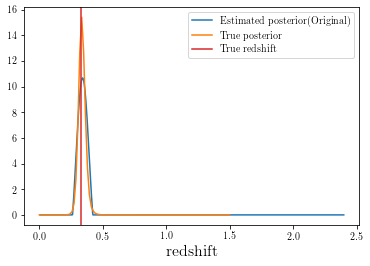

In [10]:
chosen = 9

plt.plot(y_grid_test, cdes_test[chosen], label="Estimated posterior(Original)")
plt.plot(grid, posteriors_test[chosen], label="True posterior")
plt.axvline(y_test[chosen], 0, 1, c="C3", label="True redshift")
plt.legend()
plt.xlabel("redshift")
plt.show()

It looks pretty good!
Now let's try training and validating with some Happy/Teddy data but estimating posteriors on the test set from the pzflow demo.

In [11]:
# y_train = pd.read_csv("teddyAredshifts.csv")["redshift"].to_numpy()
# x_train = pd.read_csv("teddyAphotometry.csv")[
#     ["r", "u-g", "g-r", "r-i", "i-z"]
# ].to_numpy()

# y_validation = pd.read_csv("teddyBredshifts.csv")["redshift"].to_numpy()
# x_validation = pd.read_csv("teddyBphotometry.csv")[
#     ["r", "u-g", "g-r", "r-i", "i-z"]
# ].to_numpy()

In [12]:
# # Parameterize model
# model = flexcode.FlexCodeModel(NN, max_basis, basis_system, regression_params=params)

# # Fit model - this will also choose the optimal number of neighbors `k`
# model.fit(x_train, y_train)

# # # # Tune model - Select the best number of basis
# model.tune(x_validation, y_validation)

# # # Predict new densities on grid
# cde_test_bias, y_grid_bias = model.predict(x_test, n_grid=n_grid)

In [13]:
# plt.plot(
#     y_grid_bias,
#     cde_test_bias[chosen],
#     label="Estimated posterior (biased training set)",
# )
# plt.plot(y_grid, cde_test[chosen], label="Estimated posterior (unbiased training set)")
# plt.plot(grid, posteriors_test[chosen], label="True posterior")
# plt.axvline(y_test[chosen], 0, 1, c="C3", label="True redshift")
# plt.legend()
# plt.xlabel("redshift")
# plt.show()

# 2.1 Correcting the PDFs using local regression

In [14]:
# from numba import njit

# @njit
def get_pit(cdes, z_grid, z_test):
    """
    Calculates coverage based upon the CDF

    @param cdes: a numpy array of conditional density estimates;
        each row corresponds to an observation, each column corresponds to a grid
        point
    @param z_grid: a numpy array of the grid points at which cde_estimates is evaluated
    @param z_test: a numpy array of the true z values corresponding to the rows of cde_estimates

    @returns A numpy array of values
    """

    nrow_cde, ncol_cde = cdes.shape
    n_samples = z_test.shape[0]
    n_grid_points = z_grid.shape[0]

#     if nrow_cde != n_samples:
#         raise ValueError(
#             "Number of samples in CDEs should be the same as in z_test."
#             "Currently %s and %s." % (nrow_cde, n_samples)
#         )
#     if ncol_cde != n_grid_points:
#         raise ValueError(
#             "Number of grid points in CDEs should be the same as in z_grid."
#             "Currently %s and %s." % (nrow_cde, n_grid_points)
#         )

    z_min = np.min(z_grid)
    z_max = np.max(z_grid)
    z_delta = (z_max - z_min) / (n_grid_points - 1)
#     # This line can be vectorized
    vals = [
        z_delta * np.sum(cdes[ii, np.where(z_grid < z_test[ii])[0]])
        for ii in range(n_samples)
    ]
#     vals = []
#     for ii in range(n_samples):
#         calc = z_delta * np.sum(cdes[ii, np.where(z_grid < z_test[ii])[0]])
#         vals.append(calc)
    return np.array(vals)

In [15]:
# pit_values_train = get_pit(
#     cdes_train, np.squeeze(y_grid, axis=-1), np.squeeze(y_train, axis=-1)
# )

pit_values_test = get_pit(
    cdes_test, np.squeeze(y_grid_test, axis=-1), np.squeeze(y_test, axis=-1)
)
pit_values_validation = get_pit(
    cdes_validation, np.squeeze(y_grid_validation, axis=-1), np.squeeze(y_validation)
)

## Original Global PIT

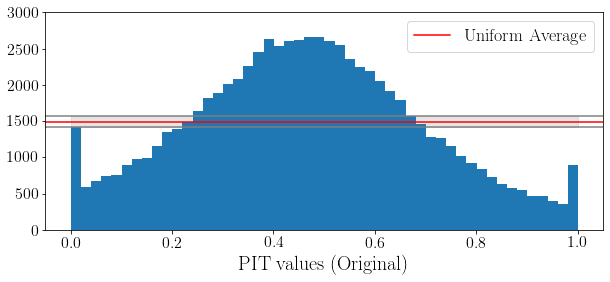

In [16]:
# good model
from plot_utils import plot_with_uniform_band
from scipy.stats import percentileofscore
fig_pit_good = plot_with_uniform_band(
    values=pit_values_test,
    ci_level=0.95,
    x_label="PIT values (Original)",
    n_bins=50,
    ylim=[0, 3000],
)
fig_pit_good

Text(0, 0.5, 'Empirical quantile (Original)')

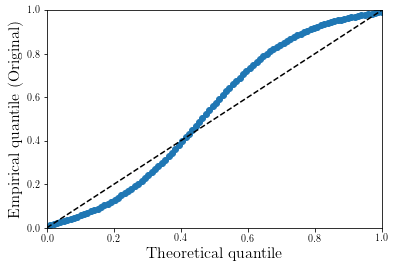

In [17]:
x = np.linspace(0,1,100)
y = [np.sum(pit_values_test<i)/len(pit_values_test) for i in x]

plt.scatter(x, y)
plt.plot(np.linspace(0,1,10),np.linspace(0,1,10),"k--")
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel("Theoretical quantile")
plt.ylabel("Empirical quantile (Original)")

## Do Global PIT correction

### Theory
The PIT is defined by the transformation 

$$PIT(z) = \int_{0}^{z} f(z'|...)dz'$$

where, $f(z'|...)$ is the conditional density estimate produced by the algorithm. 
If my estimated PDFS are right, then for a given population the true value should lie within the the $q$th quantile for $q$ fraction of times. 

Mathematically, we define the new random variable $P=PIT(z_{true})$. This means the probability distribution for the random variable P, fiven by $F(p)$ should follow a uniform distribution.

$$f'(z|...)=f(z|...)\times N(PIT(z))$$


In [18]:
num_bins = 1000
pops, bins = np.histogram(pit_values_validation, bins=num_bins, density=True)

In [19]:
n_grid=1000
correction_global = np.zeros((len(x_test), n_grid))
#VECTORIZE (also vectorize the loop inside the function)
for i in range(len(x_test)):
    correction_global[i] = get_pit(
        np.tile(cdes_test[i], (n_grid, 1)), np.squeeze(y_grid_test), np.squeeze(y_grid_test)
    )
    print(f"{i+1}/{len(x_test)}", end="\r")

In [20]:
# Binned correction
bin_idx = np.digitize(correction_global, bins) - 1
bin_idx[bin_idx == num_bins] = num_bins - 1

correction_global = pops[bin_idx]

In [21]:
# # Alternate using KDE
# from sklearn.neighbors import KernelDensity
# from sklearn.model_selection import GridSearchCV, KFold, LeaveOneOut

# plt.hist(pit_values_validation, bins=50, density=True)


# bandwidths = 10 ** np.linspace(-2, 0, 100)
# kernel = "tophat"
# grid = GridSearchCV(KernelDensity(kernel=kernel),
#                     {'bandwidth': bandwidths},
#                     cv=KFold())
# grid.fit(pit_values_validation[:, np.newaxis])

# kde = KernelDensity(kernel=kernel, bandwidth=grid.best_params_["bandwidth"]).fit(pit_values_validation[:, np.newaxis])
# X_plot = np.linspace(0,0.999, 100)
# log_dens = kde.score_samples(X_plot[:, np.newaxis])
# plt.plot(X_plot, 10**log_dens)

# for i in range(len(x_test)):
#     correction[i] = 10**kde.score_samples(correction[i][:,np.newaxis])

In [22]:
cdes_test_correct_global = cdes_test * correction_global
cdes_test_correct_global = cdes_test_correct_global / (
    np.gradient(np.squeeze(y_grid_test)) * np.sum(cdes_test_correct_global, axis=-1, keepdims=True)
)

In [37]:
np.savez(
    "globally_debiased_cde_flexcode.npz",
    x_train=x_train,
    x_validation=x_validation,
    x_test=x_test,
    
    y_train=y_train,   
    y_validation=y_validation,
    y_test=y_test,
    
    cdes_validation = cdes_validation,
    cdes_test = cdes_test,
    
    cdes_validation_grid = y_grid_validation,
    cdes_test_grid = y_grid_test,

    
    cde_test_debiased = cdes_test_correct_global,
    true_posterior_grid = grid,
    true_posterior_test = posteriors_test,
)

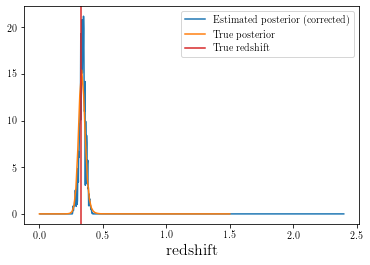

In [24]:
chosen = 9

plt.plot(y_grid_test, cdes_test_correct_global[chosen], label="Estimated posterior (corrected)")
plt.plot(grid, posteriors_test[chosen], label="True posterior")
plt.axvline(y_test[chosen], 0, 1, c="C3", label="True redshift")
plt.legend()
plt.xlabel("redshift")
plt.show()

In [25]:
pit_values_test_correct_global = get_pit(
    cdes_test_correct_global, np.squeeze(y_grid_test, axis=-1), np.squeeze(y_test, axis=-1)
)

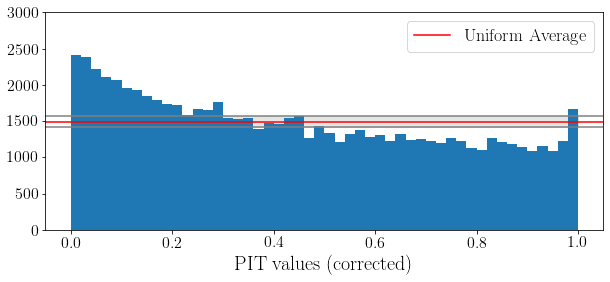

In [26]:
fig_pit_good = plot_with_uniform_band(
    values=pit_values_test_correct_global,
    ci_level=0.95,
    x_label="PIT values (corrected)",
    n_bins=50,
    ylim=[0, 3000],
)
fig_pit_good

Text(0, 0.5, 'Empirical quantile (Corrected)')

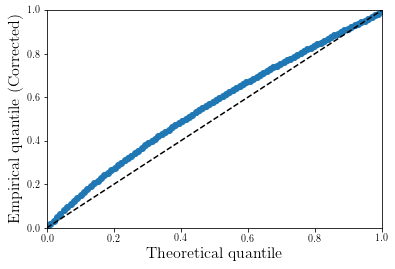

In [27]:
x = np.linspace(0,1,100)
y = [np.sum(pit_values_test_correct_global<i)/len(pit_values_test_correct_global) for i in x]

plt.scatter(x, y)
plt.plot(np.linspace(0,1,10),np.linspace(0,1,10),"k--")
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel("Theoretical quantile")
plt.ylabel("Empirical quantile (Corrected)")

In [28]:
cde_loss_val, std_cde_loss = cde_loss(cdes_test_correct_global, y_grid_test, y_test)
print('CDE Loss: %4.2f \pm %.2f' % (cde_loss_val, std_cde_loss))

CDE Loss: -11.18 \pm 0.05


# show that global callibration does not mean local

In [29]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import binom
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier, XGBRegressor


def get_local_pit(
    x_validation, pit_validation, x_test, alphas=np.linspace(0.0000000001, 0.9999, 1001),
):

    clf = XGBClassifier(
    #         n_estimators=999,
            max_depth=3,
    #         learning_rate=0.02,
            tree_method="gpu_hist",
            gpu_id=0,
            verbose=0,
    #         min_child_weight=1,
    #         subsample=0.5,
    #         sampling_method="gradient_based",
    #         colsample_bytree=1,
    #         max_bin=512,
            objective="reg:squarederror",
        )
#     clf = LogisticRegression(penalty='none', solver='saga', max_iter=10000)
#     clf = GaussianProcessClassifier(
#         RBF(0.1)
#     )  # GaussianProcessClassifier(RBF(0.1), n_jobs=-1, optimizer=None)
#     clf = QuadraticDiscriminantAnalysis()#KNeighborsClassifier()#GaussianProcessClassifier(RBF(0.1))

    ### calculate PIT values at point of interest x_test
    pit_values = np.zeros((len(x_test), len(alphas)))
    for alpha_count, alpha in enumerate(alphas):
        ind_validation = [1 * (x <= alpha) for x in pit_validation]
        rhat = clf
        rhat.fit(X=x_validation, y=ind_validation)
        pit_values[:, alpha_count] = rhat.predict_proba(x_test)[:, 1]
        print(alpha_count, end="\r")
    #     rhat = clf
    #     rhat.fit(X=x_validation, y=pit_validation)
    #     pit_values = rhat.predict(x_test)

    return pit_values

In [30]:
pit_values_local = get_local_pit(
    x_validation=x_validation,
    pit_validation=pit_values_validation,
    x_test=x_test,
    #                       alphas=np.linspace(0.0, 0.99, 99)
)

In [31]:
def numerical_derivative(x, y):
    dyc_me = (y[2:] - y [:-2])/(x[2:] - x[:-2])
    dyc_me = np.insert(dyc_me, [0,len(dyc_me)], [((y[0] - y[1])/(x[0] - x[1])), ((y[-1] - y[-2])/(x[-1] - x[-2]))])
    return dyc_me

In [32]:
pit_grid = np.zeros((len(x_test), n_grid))
for i in range(len(x_test)):
    pit_grid[i] = get_pit(
        np.tile(cdes_test[i], (n_grid, 1)), np.squeeze(y_grid_test), np.squeeze(y_grid_test)
    )
    print(f"{i+1}/{len(x_test)}", end="\r")

In [33]:
num_bins = 100
alphas=np.linspace(0.0000000001, 0.9999, 1001)
correction_local = pit_grid.copy()

for i in range(len(x_test)):
    N = numerical_derivative(alphas, pit_values_local[i])
    N = median_filter(N,100)
    correction_local[i] = interp1d(alphas, N, kind="cubic",fill_value="extrapolate")(correction_local[i]) #replace with spline?
#     correction_local[i] = np.interp(correction_local[i], alphas, N) #replace with spline?
#     bin_idx = np.digitize(N, alphas) - 1
#     bin_idx[bin_idx == num_bins] = num_bins - 1
#     correction_local[i] = N[bin_idx]
    
    print(f"{i+1}/{len(x_test)}", end="\r")

correction_local[correction_local<=0]=1
cdes_test_correct_local = cdes_test * correction_local
cdes_test_correct_local = cdes_test_correct_local / (
    np.gradient(np.squeeze(y_grid_test)) * np.sum(cdes_test_correct_local, axis=-1, keepdims=True)
)

In [34]:
pit_values_test_correct_local = get_pit(
    cdes_test_correct_local, np.squeeze(y_grid_test, axis=-1), np.squeeze(y_test, axis=-1)
)


In [35]:
mask = (pit_values_test_correct_local>=0) & (pit_values_test_correct_local<=1)
mask.sum()/len(mask)

0.9989538205668147

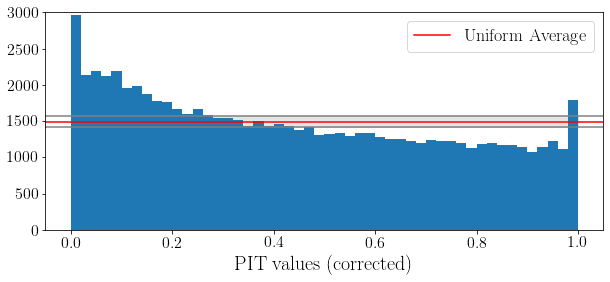

In [36]:
fig_pit_good = plot_with_uniform_band(
    values=pit_values_test_correct_local[mask],
    ci_level=0.95,
    x_label="PIT values (corrected)",
    n_bins=50,
    ylim=[0, 3000],
)
fig_pit_good

In [38]:
np.savez(
    "locally_debiased_cde_flexcode.npz",
    x_train=x_train,
    x_validation=x_validation,
    x_test=x_test[mask],
    
    y_train=y_train,   
    y_validation=y_validation,
    y_test=y_test[mask],
    
    cdes_validation = cdes_validation,
    cdes_test = cdes_test[mask],
    
    cdes_validation_grid = y_grid_validation,
    cdes_test_grid = y_grid_test,

    
    cde_test_debiased = cdes_test_correct_local[mask],
    true_posterior_grid = grid,
    true_posterior_test = posteriors_test[mask],
)

Text(0, 0.5, 'Empirical quantile (Corrected)')

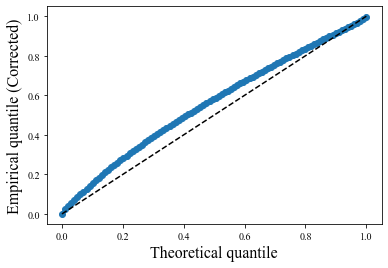

In [194]:
x = np.linspace(0,1,100)
p = pit_values_test_correct_local[mask]
y = [np.sum(p<i)/len(p) for i in x]

plt.scatter(x, y)
plt.plot(np.linspace(0,1,10),np.linspace(0,1,10),"k--")
# plt.xlim(0,1)
# plt.ylim(0,1)
plt.xlabel("Theoretical quantile")
plt.ylabel("Empirical quantile (Corrected)")

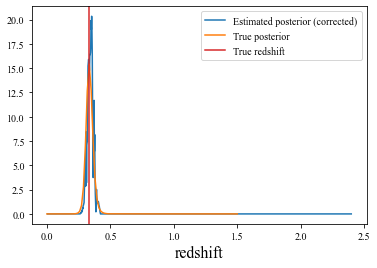

In [195]:
chosen = 9

plt.plot(y_grid_test, cdes_test_correct_local[chosen], label="Estimated posterior (corrected)")
plt.plot(grid, posteriors_test[chosen], label="True posterior")
plt.axvline(y_test[chosen], 0, 1, c="C3", label="True redshift")
plt.legend()
plt.xlabel("redshift")
plt.show()

In [196]:
cde_loss_val, std_cde_loss = cde_loss(cdes_test_correct_local[mask], y_grid_test, y_test[mask])
print('CDE Loss: %4.2f \pm %.2f' % (cde_loss_val, std_cde_loss))

CDE Loss: -11.01 \pm 0.06


In [197]:
np.random.seed(42)
idx = np.random.permutation(len(x_test))
ind_split_train = int(np.ceil(0.5 * len(x_test)))
pit_values_local_corrected = get_local_pit(
    x_validation=x_test[idx[:ind_split_train]],
    pit_validation=pit_values_test_correct_local[idx[:ind_split_train]],
    x_test=x_test[idx[ind_split_train:]],
    #                       alphas=np.linspace(0.0, 0.99, 99)
)

In [77]:
# pit_values = get_local_pit(x_validation=x_test, pit_validation=pit_values_test_correct,
#                       x_test=x_test,
# #                       alphas=np.linspace(0.0, 0.99, 99)
#                      )

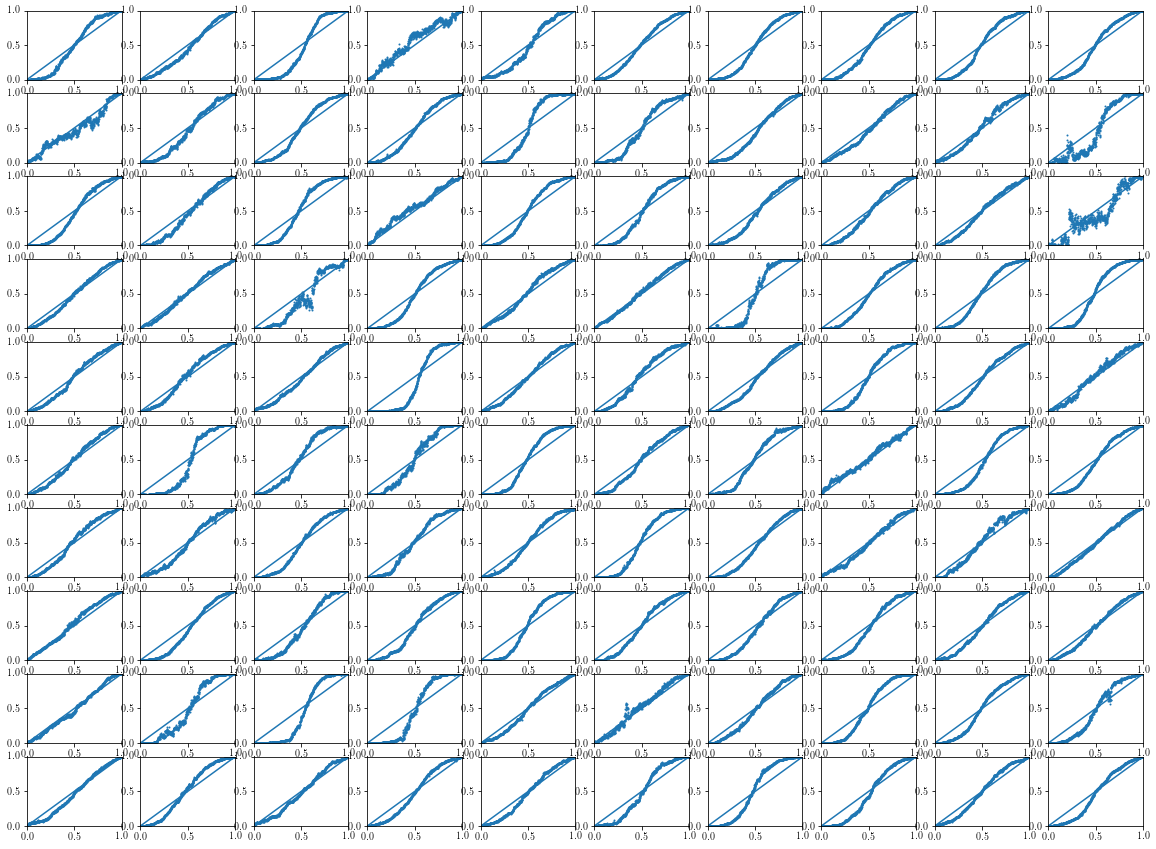

In [79]:
np.random.seed(42)
random_idx = np.random.choice(len(x_test), 100, replace=False)

fig, axs = plt.subplots(10, 10, figsize=(20, 15))
axs = np.ravel(axs)
for count, index in enumerate(random_idx):
    axs[count].scatter(np.linspace(0.0, 0.9999, 1001),pit_values_local[idx[:ind_split_train]][index], s=1)
#     axs[count].scatter(np.linspace(0.0, 0.9999, 1001),pit_values_local_corrected[index], s=1)
    axs[count].plot(np.linspace(0,1,10), np.linspace(0,1,10))
    axs[count].set_xlim(0,1)
    axs[count].set_ylim(0,1)
#     axs[count].hist(pit_values[index], bins=100)

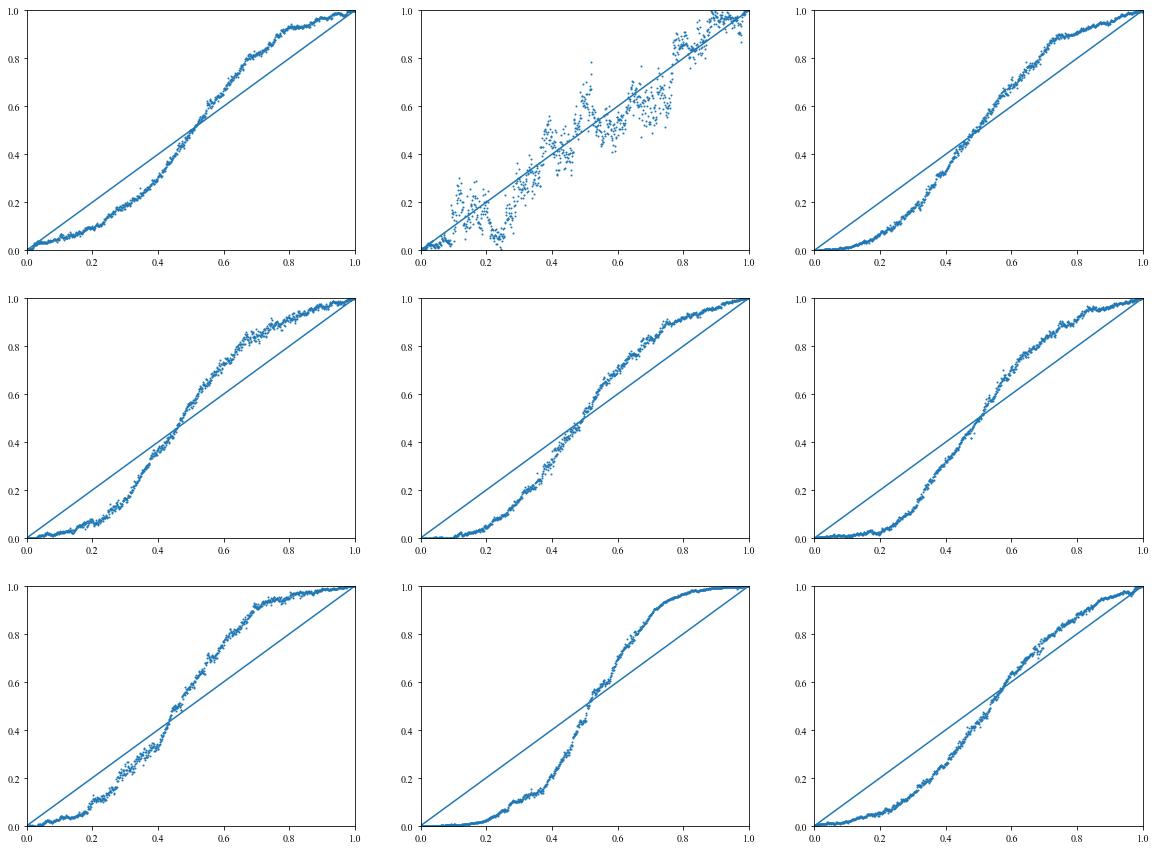

In [203]:
np.random.seed(42)
random_idx = np.random.choice(int(len(x_test)/2), 9, replace=False)+1

fig, axs = plt.subplots(3,3, figsize=(20, 15))
axs = np.ravel(axs)
for count, index in enumerate(random_idx):
#     axs[count].scatter(np.linspace(0.0, 0.9999, 1001),pit_values_local[index], s=1)
    axs[count].scatter(np.linspace(0.0, 0.9999, 1001),pit_values_local[idx[:ind_split_train]][index], s=1)
    axs[count].plot(np.linspace(0,1,10), np.linspace(0,1,10))
    axs[count].set_xlim(0,1)
    axs[count].set_ylim(0,1)
#     axs[count].hist(pit_values[index], bins=100)

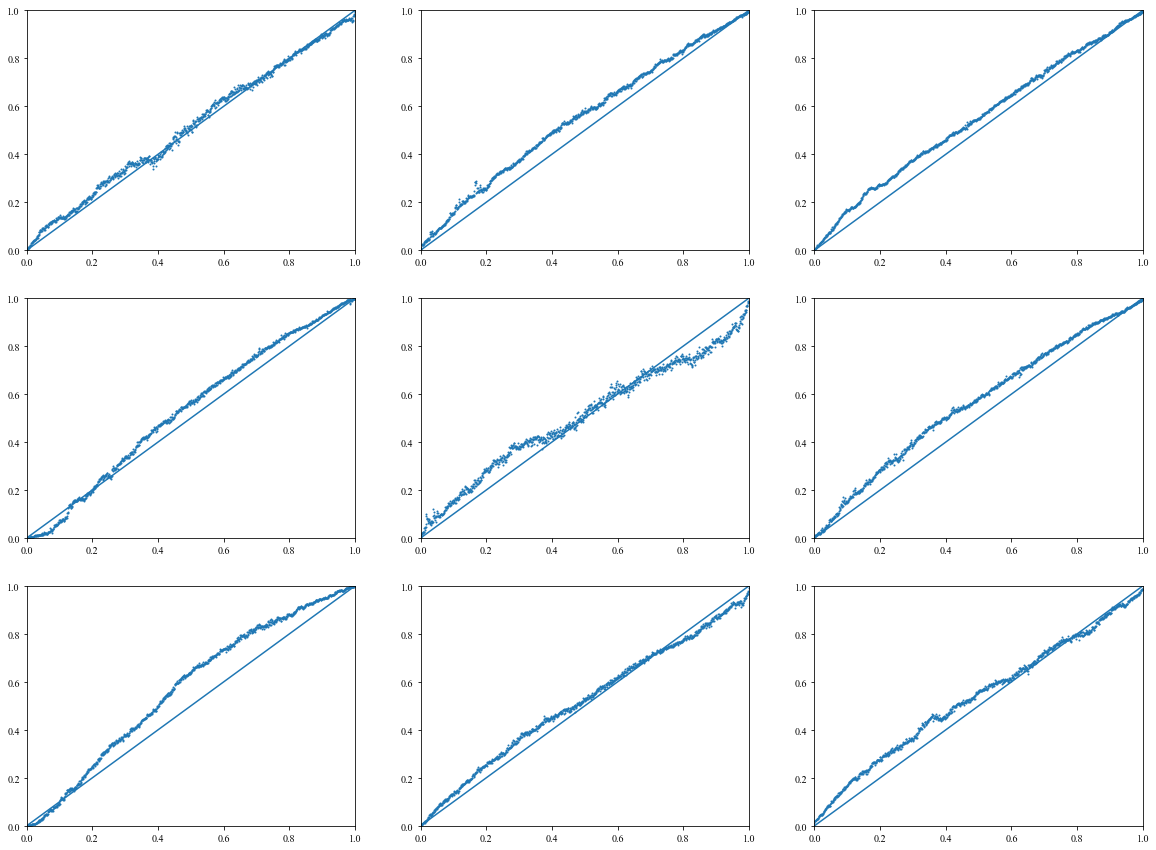

In [202]:
np.random.seed(42)
random_idx = np.random.choice(int(len(x_test)/2), 9, replace=False)+1

fig, axs = plt.subplots(3,3, figsize=(20, 15))
axs = np.ravel(axs)
for count, index in enumerate(random_idx):
#     axs[count].scatter(np.linspace(0.0, 0.9999, 1001),pit_values_local[index], s=1)
    axs[count].scatter(np.linspace(0.0, 0.9999, 1001),pit_values_local[index], s=1)
    axs[count].plot(np.linspace(0,1,10), np.linspace(0,1,10))
    axs[count].set_xlim(0,1)
    axs[count].set_ylim(0,1)
#     axs[count].hist(pit_values[index], bins=100)

In [92]:
def better_step(bin_edges, y, yerr=None, ax=None, **kwargs):
    """A 'better' version of matplotlib's step function
    Given a set of bin edges and bin heights, this plots the thing
    that I wish matplotlib's ``step`` command plotted. All extra
    arguments are passed directly to matplotlib's ``plot`` command.
    Args:
        bin_edges: The bin edges. This should be one element longer than
            the bin heights array ``y``.
        y: The bin heights.
        yerr: symmetric error on y.
        ax (Optional): The axis where this should be plotted.
    """
    new_x = [a for row in zip(bin_edges[:-1], bin_edges[1:]) for a in row]
    new_y = [a for row in zip(y, y) for a in row]
    if ax is None:
        ax = plt.gca()
    p = ax.plot(new_x, new_y, **kwargs)
    if yerr is not None:
        new_yerr = np.array([a for row in zip(yerr, yerr) for a in row])
        ax.fill_between(
            new_x, new_y + new_yerr, new_y - new_yerr, alpha=0.1, color=p[0].get_color()
        )
    return ax

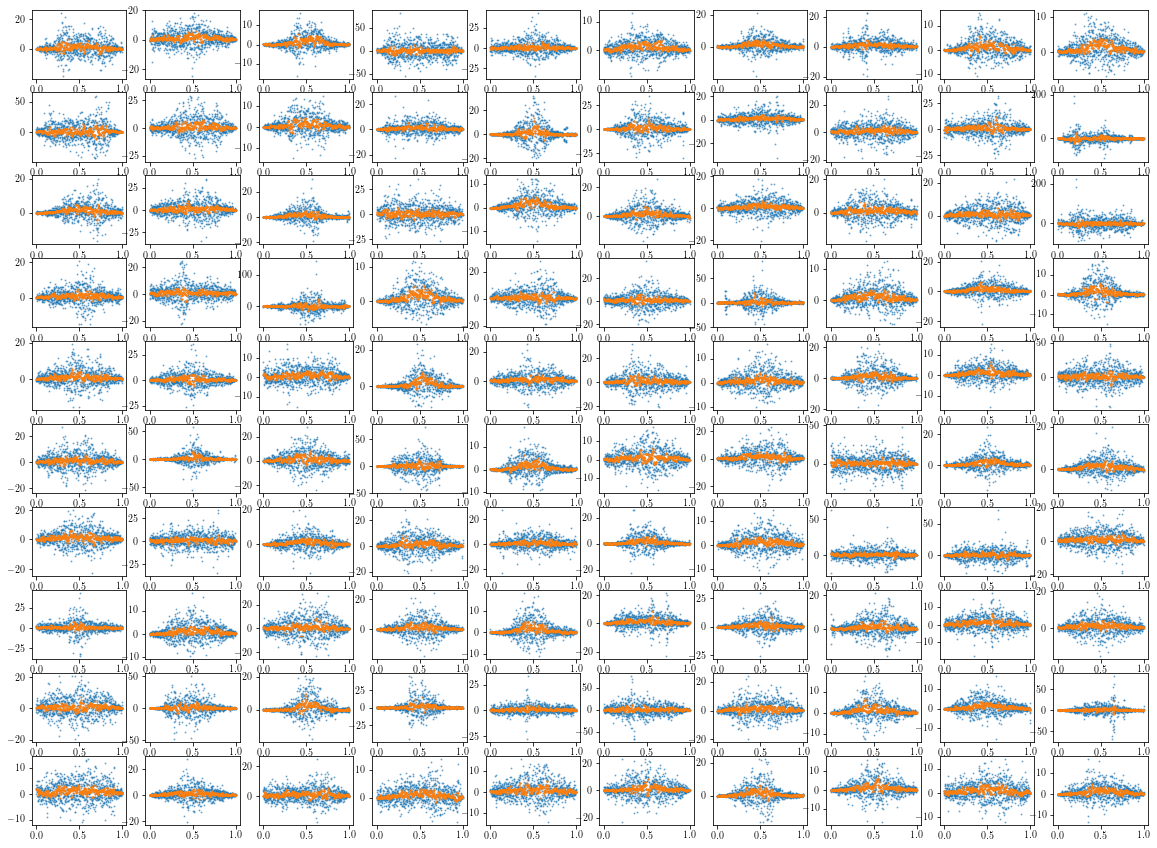

In [111]:
np.random.seed(42)
from scipy.stats import binned_statistic
from scipy.ndimage import median_filter
random_idx = np.random.choice(len(x_test), 100, replace=False)
N = np.zeros((len(x_test), len(alphas)))
for i in range(len(x_test)):
    N[i] = numerical_derivative(alphas, pit_values_local[i])
fig, axs = plt.subplots(10, 10, figsize=(20, 15))
axs = np.ravel(axs)

for count, index in enumerate(random_idx):
    NB, bin_edges, _ = binned_statistic(alphas, N[index], statistic="median", bins=100)
#     _=better_step(bin_edges, NB, ax=axs[count],color="k")
    axs[count].scatter(alphas,N[index], s=1, alpha=0.5)
    axs[count].scatter(alphas,median_filter(N[index],15), s=1, alpha=0.5)
#     axs[count].scatter(y_grid_test,correction_local[index])
    

In [174]:
cde_loss_val, std_cde_loss = cde_loss(cdes_test_correct_local[mask], y_grid_test, y_test[mask])
print('CDE Loss: %4.2f \pm %.2f' % (cde_loss_val, std_cde_loss))

CDE Loss: -7.17 \pm 0.66


In [ ]:
np.random.seed(42)
random_idx = np.random.choice(len(x_test), 100, replace=False)

fig, axs = plt.subplots(10, 10, figsize=(20, 15))
axs = np.ravel(axs)
for count, index in enumerate(random_idx):
    axs[count].hist(pit_values[index], bins=100)

# Next steps:
- Smooth out the Q-Q plots for correction (currently using linear interpolation)
- better numerical derivative (currently using central differences)

## 3. Evaluating the performance of estimated photo-$z$ posterior PDFs

Once we have estimated photo-$z$ posterior PDFs, we need a way to determine if they're actually any good.
Since the tutorial has only one method but multiple training/validation sets, that's all we can compare for now.

### Metrics of estimated photo-$z$ posteriors and true redshifts

First, let's try out a couple metrics of estimated photo-$z$ posteriors that do not require knowledge of the true photo-$z$ posteriors.
There's additional functionality for the case of having true redshifts but not true posteriors in [cdetools](https://github.com/tpospisi/cdetools) and [cde-diagnostics](https://github.com/zhao-david/CDE-diagnostics), but this should give a general idea.

In [ ]:
from cdetools import cde_loss, cdf_coverage, hpd_coverage

The Probability Integral Transform (PIT) is defined as 
\begin{equation}
PIT = \int_{-\infty}^{z_{true}} p(z | \vec{d}, \{z_{n}, \vec{d}_{n}\}_{N}, \pi) dz .
\end{equation}
A histogram of PIT values is commonly used to assess how consistent a population of photo-$z$ PDFs are with the true redshifts.
Ideally, it would be a uniform distribution, meaning N% of galaxies have their true redshift within the Nth percentile of their estimated photo-$z$ posterior PDF.

In [ ]:
pit_values = cdf_coverage.cdf_coverage(cde_test, y_grid, y_test)
pit_values_bias = cdf_coverage.cdf_coverage(cde_test_bias, y_grid_bias, y_test)

plt.hist(pit_values, alpha=0.5, bins=100, label="representative")
plt.hist(pit_values_bias, alpha=0.5, bins=100, label="biased")
plt.ylim(0, 100)
plt.legend()
plt.xlabel("PIT")

The Highest Predictive Density (HPD) 
\begin{equation}
HPD = \int_{z': p(z' | \vec{d}_{i}, \{z_{n}, \vec{d}_{n}\}_{N}, \pi) \geq p(z | \vec{d}_{i}, \{z_{n}, \vec{d}_{n}\}_{N}, \pi)} p(z' | \vec{d}_{i}, \{z_{n}, \vec{d}_{n}\}_{N}, \pi) dz
\end{equation}
is like the area of the PDF where it exceeds a given value.
Over a population, it would ideally be flat, like the PIT.
[A talk by David Zhao (CMU)](https://drive.google.com/file/d/1uvPtK_RcTUHEwt0ZYld41VKEPHnehWbN/view) has a lovely visualization of the HPD.

In [ ]:
hpd_cov = hpd_coverage.hpd_coverage(cde_test, y_grid, y_test)
hpd_cov_bias = hpd_coverage.hpd_coverage(cde_test_bias, y_grid_bias, y_test)

plt.hist(hpd_cov, alpha=0.5, bins=100, label="representative")
plt.hist(hpd_cov_bias, alpha=0.5, bins=100, label="biased")
plt.ylim(0, 100)
plt.legend()
plt.xlabel("HPD")

The CDE loss 
\begin{equation}
\hat{L} = \frac{1}{K} \sum_{i=1}^{K} \int \left(p(z | \vec{d}_{i}, \{z_{n}, \vec{d}_{n}\}_{N}, \pi)\right)^{2} dz - \frac{2}{K} \sum_{i=1}^{K} p(z_{i} | \vec{d}_{i}, \{z_{n}, \vec{d}_{n}\}_{N}, \pi)
\end{equation}
approximates the true posterior from the estimated posterior evaluated at the true redshift.
It's explained quite well in [a talk by Nic Dalmasso (CMU)](https://www.dropbox.com/s/2r4tl4qv0iyqo9b/STAMPS_LSST_CDE_Tools_Presentation.pdf?dl=0).
A lower value indicates a better estimator.

In [ ]:
print(cde_loss.cde_loss(cde_test, y_grid, y_test))
print(cde_loss.cde_loss(cde_test_bias, y_grid_bias, y_test))

### Comparison of estimated and true photo-$z$ posterior PDFs

There are two categories of metrics of approximated and true PDF: 
those that either rely upon or force the normalization condition $\int p(z) dz = 1$and those that evaluate differences between arbitrary functions.
`qp` [(Malz, et al 2018)](https://arxiv.org/abs/1806.00014) is a package for manipulating univariate PDFs under many parameterizations and includes a few comparison metrics.

The [original version](https://github.com/aimalz/qp) consistently enforced normalization but had limited functionality, whereas the [new version](https://github.com/LSSTDESC/qp) includes many more parameterizations whose usage is "at your own risk" in terms of possibly violating normalization.
We'll use the new version for the sake of speed but evaluating metrics using simplified functions ported from the old version due to a (hopefully transient) bug in the handling of large sets of posteriors.
The first step is to get both the true posteriors and the approximations evaluated on the same grid of redshifts.

_This content is adapted from the [qp demo](https://github.com/LSSTDESC/qp/blob/master/docs/notebooks/demo.ipynb), written by Alex Malz (GCCL@RUB), Phil Marshall (SLAC), and Eric Charles (SLAC), and [qp metrics demo](https://github.com/LSSTDESC/qp/blob/master/docs/notebooks/kld.ipynb), written by Alex Malz (GCCL@RUB) and Phil Marshall (SLAC)._

In [ ]:
# P = qp.Ensemble(qp.interp, data=dict(xvals=grid.reshape(grid.shape[0]), yvals=posteriors_test))
Q = qp.Ensemble(
    qp.interp, data=dict(xvals=y_grid.reshape(y_grid.shape[0]), yvals=cde_test)
)
Q_bias = qp.Ensemble(
    qp.interp,
    data=dict(xvals=y_grid.reshape(y_grid_bias.shape[0]), yvals=cde_test_bias),
)
grid, approx_pdf_on_grid = Q.gridded(grid)
grid, approx_pdf_on_grid_bias = Q_bias.gridded(grid)

The Kullback Leibler Divergence (KLD)
\begin{equation}
KLD = \int_{-\infty}^{\infty} p(z | \vec{d}) \log\left[\frac{p(z | \vec{d}, \{z_{n}, \vec{d}_{n}\}_{N}, \pi)}{p(z | \vec{d})}\right] dz
\end{equation}
is a directional measure of how much information is lost by using the estimated $p(z | \vec{d}, \{z_{n}, \vec{d}_{n}\}_{N}, \pi)$ instead of the true $p(z | \vec{d})$.
We want the KLD for each galaxy to be low.

In [ ]:
KLDs = np.array(
    [
        qp.metrics.quick_kld(p, q, dx=np.mean(grid[1:] - grid[:-1]))
        for p, q in zip(posteriors_test, approx_pdf_on_grid)
    ]
)
KLDs_bias = np.array(
    [
        qp.metrics.quick_kld(p, q, dx=np.mean(grid[1:] - grid[:-1]))
        for p, q in zip(posteriors_test, approx_pdf_on_grid_bias)
    ]
)

plt.hist(np.log(KLDs), alpha=0.5, bins=100, label="representative", density=True)
plt.hist(np.log(KLDs_bias), alpha=0.5, bins=100, label="biased", density=True)
plt.xlabel("KLD")
plt.legend()
plt.semilogy()

The root-mean-square-error (RMSE) is a symmetric measure commonly used to compare 1D functions.
**TODO: write it out?** Similarly, a lower value corresponds to a more closely approximating posterior PDF.

In [ ]:
RMSEs = np.array(
    [
        qp.metrics.quick_rmse(p, q, N=granularity)
        for p, q in zip(posteriors_test, approx_pdf_on_grid)
    ]
)
RMSEs_bias = np.array(
    [
        qp.metrics.quick_rmse(p, q, N=granularity)
        for p, q in zip(posteriors_test, approx_pdf_on_grid_bias)
    ]
)

plt.hist(np.log(RMSEs), alpha=0.5, bins=100, label="representative", density=True)
plt.hist(np.log(RMSEs_bias), alpha=0.5, bins=100, label="biased", density=True)
plt.xlabel("RMSE")
plt.legend()